In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats
import scipy.optimize as opt

In [4]:
from tqdm import tqdm

In [5]:
n_process = 32

# 1. parameters

In [6]:
T = 120
N = 100000

In [7]:
d = 2
## order: 1, U, X, A, I
alpha = np.array([0, 0.5, 0, 1, 0])
# beta = np.array([1, -0.2, 0, 0, 0])
gamma = np.array([-2.5, 0, 0, 4, 100/N])
phi = 0.95

In [8]:
betas = np.array([
    np.linspace(1, 1.5, 21),     
    np.linspace(0, -1, 21),
]).T

$$P_t = 1 - \exp\{- \frac{\rho_t}{N} h I_t\}$$

$$\rho_t = \exp\{ - \beta_1 - \beta_A A_t - \beta_U U_t - \beta_X X_t \}$$

In [9]:
pC = 0.2
pD = 0.2

## seed values

In [10]:
I0 = 100
E0 = 0
S0 = N - E0 - I0

## simulation setting

In [11]:
num_beta = 21
num_sim = 1000

# 2. Fit

In [12]:
import istarmap

In [13]:
from multiprocessing import Pool
from itertools import starmap
from helper_function_seir import fit_EEnc_seir

In [15]:
lamda = 0.2
num_MC = 1000
num_iter = 300

In [14]:
import warnings
from statsmodels.tools.sm_exceptions import DomainWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DomainWarning)

In [ ]:
for iter_beta in tqdm(np.arange(num_beta), desc='beta', leave=None, position=0):
    data = pd.read_feather('data/simulation_phantom_%.2d.feather'%iter_beta)
    
    with Pool(n_process) as p:
        bsim = list(tqdm(p.istarmap(fit_EEnc_seir, map(
            lambda iter_sim: (
                data[data['sim']==iter_sim], pC, pD, N,
                lamda, num_iter, num_MC
            ), range(num_sim)
        )), total = num_sim, desc='SIM', leave=None, position=0, smoothing=0))

    np.savez('result/phantom_EE_%.2d.npz'%iter_beta, bsim = bsim)

SIM:  30%|██▉       | 297/1000 [07:38<18:04,  1.54s/it]

# 3. Result

In [21]:
bsim = np.array([np.load('result/phantom_EE_%.2d.npz'%iter_beta)['bsim']
                 for iter_beta in np.arange(num_beta)])

In [22]:
from matplotlib import ticker

In [23]:
betas[:,-1]

array([ 0.  , -0.05, -0.1 , -0.15, -0.2 , -0.25, -0.3 , -0.35, -0.4 ,
       -0.45, -0.5 , -0.55, -0.6 , -0.65, -0.7 , -0.75, -0.8 , -0.85,
       -0.9 , -0.95, -1.  ])

In [28]:
bsim[np.abs(bsim) > 10] = None

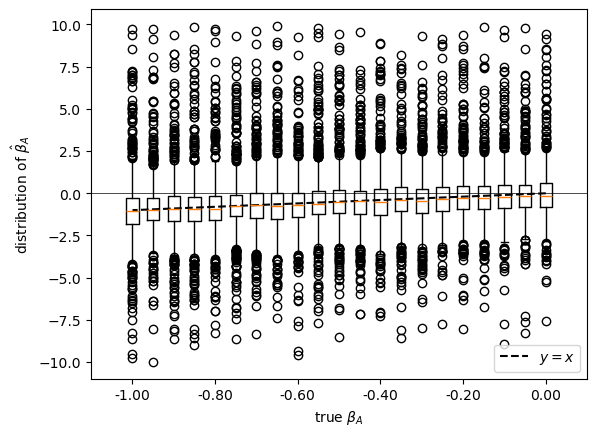

In [29]:
plt.boxplot([bs[~np.isnan(bs)] for bs in bsim[:,:,-1]], positions=betas[:,-1], widths=0.03)
plt.plot(betas[:,-1], betas[:,-1], linestyle='--', color='black', label=r'$y=x$')
plt.axhline(y=0, linewidth=0.5, color='black')
plt.xlim(np.min(betas[:,-1])-0.1, np.max(betas[:,-1])+0.1)
plt.xticks(np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6), 
           np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
plt.ylabel(r'distribution of $\hat\beta_A$'); plt.xlabel(r'true $\beta_A$'); plt.legend()
plt.show()

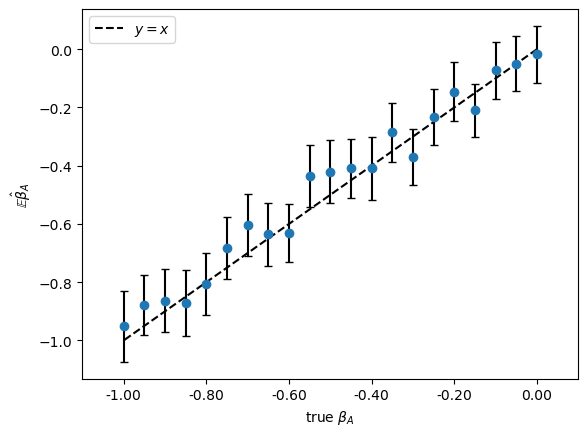

In [34]:
plt.errorbar(betas[:,-1], np.nanmean(bsim[:,:,-1], -1), yerr=2*np.nanstd(bsim[:,:,-1],-1)/np.sqrt(num_sim), 
             ecolor='black', capsize=3, fmt="o")
plt.plot(betas[:,-1], betas[:,-1], linestyle='--', color='black', label=r'$y=x$')
plt.xlim(np.min(betas[:,-1])-0.1, np.max(betas[:,-1])+0.1)
plt.xticks(np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6), 
           np.linspace(np.min(betas[:,-1]), np.max(betas[:,-1]), 6))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
plt.xlabel(r'true $\beta_A$'); plt.ylabel(r'$\mathbb{E}\hat\beta_A$'); plt.legend()
plt.show()